# Experimentation: Design, Diagnose, and Analyze (Overlapping Tests)


In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Connect to database
conn = duckdb.connect('../bree_case_study.db')

### Part A)

In [2]:
# Mean / SD / N for Revenue per Disbursed Loan (RPDL) - PriceTest_A only
# This gives the baseline mean, standard deviation, and sample size for control arm A

mean_rpdl_A_q = """
SELECT
  ROUND(AVG(revenue), 2)        AS mean_rpdl,   -- mean revenue per disbursed loan ($)
  COUNT(*)                      AS n_loans      -- number of disbursed loans
FROM v_loans_with_experiments
WHERE is_disbursed = 1
  AND price_test_group = 'A';
"""

mean_rpdl_A_df = conn.execute(mean_rpdl_A_q).fetchdf()
mean_rpdl_A_df



,mean_rpdl,n_loans
0,0.32,1756


In [3]:
# Get experiment window for PriceTest_A disbursed loans
# Returns: start_date, end_date, total_days in experiment window
exp_window_q = """
SELECT
  MIN(disbursed_at_utc)::DATE AS start_date,
  MAX(disbursed_at_utc)::DATE AS end_date,
  DATE_DIFF('day', MIN(disbursed_at_utc), MAX(disbursed_at_utc)) + 1 AS total_days
FROM v_loans_with_experiments
WHERE is_disbursed = 1
  AND price_test_group = 'A';
"""

exp_window_df = conn.execute(exp_window_q).fetchdf()
exp_window_df


,start_date,end_date,total_days
0,2025-03-17,2025-08-01,138


In [4]:
# Power analysis for RPDL (two-sample diff-in-means)
# Calculates required n per arm and horizon (days) for MDE = 10%, 15%, 20%
power_analysis_q = """
WITH params AS (
  SELECT 
    0.32::DOUBLE AS mu,              -- mean RPDL baseline ($)
    0.32::DOUBLE AS sigma,           -- assume σ ≈ µ
    13.0::DOUBLE  AS per_arm_daily,  -- ~1756 / 138 ≈ 12.7 ≈ 13 disbursed loans per arm/day
    1.96::DOUBLE  AS z_alpha,        -- alpha=0.05 (two-sided test)
    0.84::DOUBLE  AS z_power         -- power=80%
),
mdes AS (
  SELECT 0.10 AS mde UNION ALL
  SELECT 0.15 UNION ALL
  SELECT 0.20
),
calc AS (
  SELECT
    m.mde,
    p.mu,
    p.sigma,
    p.per_arm_daily,
    POW(p.z_alpha + p.z_power, 2) AS zsum2,
    (m.mde * p.mu)               AS delta   -- absolute effect size in $
  FROM mdes m CROSS JOIN params p
)
SELECT
  CONCAT(CAST(ROUND(mde*100,0) AS INT), '%')   AS mde,           -- relative lift
  ROUND(mu * mde, 2)                           AS abs_delta_usd, -- absolute $ lift
  CEIL(2 * zsum2 * sigma * sigma / (delta * delta)) AS n_per_arm, -- sample size per arm
  CEIL(CEIL(2 * zsum2 * sigma * sigma / (delta * delta)) / per_arm_daily) AS horizon_days
FROM calc
ORDER BY mde;
"""

power_analysis_df = conn.execute(power_analysis_q).fetchdf()
power_analysis_df


,mde,abs_delta_usd,n_per_arm,horizon_days
0,10%,0.03,1568.0,121.0
1,15%,0.05,697.0,54.0
2,20%,0.06,392.0,31.0


### Part B) Naiive difference in means

- Get means to calculate naiive difference

In [5]:
# Naïve group-by means for TipPrompt_2025Q2
# Metrics: tip take-rate, mean tip (all loans), mean tip (conditional on tip>0),
#          revenue per disbursed loan (RPDL), default rate

naive_tip_metrics_q = """
WITH base AS (
  SELECT
    tip_test_group,
    tip_amount,
    revenue,
    is_default
  FROM v_loans_with_experiments
  WHERE is_disbursed = 1
    AND tip_test_group IN ('control','persuasive','social_proof')
)
SELECT
  tip_test_group,
  COUNT(*) AS loans,
  AVG(CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END)                    AS tip_take_rate,
  AVG(tip_amount)                                                     AS mean_tip_all,       -- $ per disbursed loan
  AVG(CASE WHEN tip_amount > 0 THEN tip_amount END)                   AS mean_tip_given_tip, -- $ among tippers only
  AVG(revenue)                                                        AS rpdl,               -- total revenue per disbursed loan
  AVG(is_default)                                                     AS default_rate
FROM base
GROUP BY tip_test_group
ORDER BY tip_test_group
"""

naive_df = conn.execute(naive_tip_metrics_q).fetchdf()
naive_df


,tip_test_group,loans,tip_take_rate,mean_tip_all,mean_tip_given_tip,rpdl,default_rate
0,control,1171,0.111016,0.281810,2.538462,1.681383,0.250213
1,persuasive,1052,0.152091,0.424905,2.793750,2.019021,0.251901
2,social_proof,1014,0.119329,0.314596,2.636364,1.662643,0.253452


- Get naiive difference in mean

In [6]:
# Ensure control row exists
assert (naive_df["tip_test_group"] == "control").any(), "No control arm found."

ctrl = naive_df.loc[naive_df["tip_test_group"]=="control"].iloc[0]

def pp(x):  # percentage points
    return 100 * x

out_rows = []
for _, r in naive_df.iterrows():
    if r["tip_test_group"] == "control":
        continue
    out_rows.append({
        "tip_variant": r["tip_test_group"],
        "loans": int(r["loans"]),
        # Take-rate: report absolute pp change
        "Δ take-rate (pp)": round(pp(r["tip_take_rate"] - ctrl["tip_take_rate"]), 2),
        # Tip size (conditional): absolute $ change
        "Δ mean tip | tip>0 ($)": round((r["mean_tip_given_tip"] or 0) - (ctrl["mean_tip_given_tip"] or 0), 2),
        # RPDL: relative % lift and absolute $
        "RPDL lift (%)": round(100 * (r["rpdl"] - ctrl["rpdl"]) / ctrl["rpdl"], 2) if ctrl["rpdl"] else np.nan,
        "Δ RPDL ($)": round(r["rpdl"] - ctrl["rpdl"], 2),
        # Default guardrail: pp change (negative is good)
        "Δ default (pp)": round(pp(r["default_rate"] - ctrl["default_rate"]), 3),
    })

naive_effects_df = pd.DataFrame(out_rows).sort_values("tip_variant")
naive_effects_df


,tip_variant,loans,Δ take-rate (pp),Δ mean tip | tip>0 ($),RPDL lift (%),Δ RPDL ($),Δ default (pp)
0,persuasive,1052,4.11,0.26,20.08,0.34,0.169
1,social_proof,1014,0.83,0.10,-1.11,-0.02,0.324


### Part B) Adjusted estimate controlling for price variant, baseline risk decile, province, and loan amount (using regression)

0. Load analysis frame (disbursed loans only)

In [7]:
# Pull loan-level outcomes + covariates
adj_base_q = """
SELECT
  tip_test_group,               -- control / persuasive / social_proof
  price_test_group,             -- A / B
  risk_score_decile,            -- 1..10
  province,                     -- categorical
  amount,                       -- loan amount (control)
  tip_amount,                   -- outcomes
  revenue,
  is_default
FROM v_loans_with_experiments
WHERE is_disbursed = 1
  AND tip_test_group IN ('control','persuasive','social_proof')
"""
adj_df = conn.execute(adj_base_q).fetchdf()

import pandas as pd, numpy as np
adj_df["tip_taken"] = (adj_df["tip_amount"] > 0).astype(int)
adj_df.head()


,tip_test_group,price_test_group,risk_score_decile,province,amount,tip_amount,revenue,is_default,tip_taken
0,persuasive,not_assigned,1,QC,92.25,0.0,0.00,1,0
1,persuasive,B,1,BC,158.24,1.0,3.05,0,1
2,social_proof,A,1,SK,192.85,0.0,0.00,0,0
3,social_proof,B,1,MB,171.56,0.0,5.22,1,0
4,persuasive,B,1,BC,96.35,0.0,4.29,0,0


In [8]:
# Map marginal-effects table columns across statsmodels versions
def _map_me_cols(sf):
    # normalize names
    norm = {c: c.lower().strip().replace(' ', '').replace('|','') for c in sf.columns}
    inv  = {v:k for k,v in norm.items()}

    effect = inv.get('dy/dx') or inv.get('dydx') or inv.get('margeff') or list(sf.select_dtypes('number').columns)[0]
    pval   = inv.get('pr(>z)') or inv.get('pvalue') or inv.get('p>z') or inv.get('p>|z|')
    ci_lo  = inv.get('conf.int.low') or inv.get('confintlow') or inv.get('[0.025') or next((c for c,v in norm.items() if v.endswith('0.025]')), None)
    ci_hi  = inv.get('cont.int.hi.') or inv.get('conf.int.hi.') or inv.get('confinthigh') or inv.get('0.975]') or next((c for c,v in norm.items() if v.endswith('0.975]')), None)
    return effect, pval, ci_lo, ci_hi

# exact term labels for tip contrasts (as seen in your outputs)
TIP_TERMS = [
    "C(tip_test_group, Treatment('control'))[T.persuasive]",
    "C(tip_test_group, Treatment('control'))[T.social_proof]",
]


1. Tip take-rate — Logistic regression with AME (pp)

In [9]:
import statsmodels.api as sm, statsmodels.formula.api as smf

formula_take = """
tip_taken ~ C(tip_test_group, Treatment('control'))
         + C(price_test_group, Treatment('A'))
         + C(risk_score_decile)
         + C(province)
         + amount
"""
logit_take = smf.logit(formula_take, data=adj_df).fit(disp=0)

ame_take = logit_take.get_margeff(at='overall', method='dydx')
sf = ame_take.summary_frame()

eff_col, p_col, lo_col, hi_col = _map_me_cols(sf)
take_rows = sf.loc[TIP_TERMS, [eff_col, p_col, lo_col, hi_col]].copy()

take_rows["effect_pp"]  = 100 * take_rows[eff_col]
take_rows["ci_low_pp"]  = 100 * take_rows[lo_col]
take_rows["ci_high_pp"] = 100 * take_rows[hi_col]
take_rows.rename(columns={p_col: "p_value"}, inplace=True)
take_rows = take_rows[["effect_pp","ci_low_pp","ci_high_pp","p_value"]].round(3)
take_rows


,effect_pp,ci_low_pp,ci_high_pp,p_value
"C(tip_test_group, Treatment('control'))[T.persuasive]",3.785,1.037,6.533,0.007
"C(tip_test_group, Treatment('control'))[T.social_proof]",0.996,-1.916,3.909,0.503


2) mean tip (incl zeros) — OLS with robust SE (HC1)

In [10]:
formula_tip = """
tip_amount ~ C(tip_test_group, Treatment('control'))
          + C(price_test_group, Treatment('A'))
          + C(risk_score_decile)
          + C(province)
          + amount
"""
ols_tip = smf.ols(formula_tip, data=adj_df).fit(cov_type="HC1")

params  = ols_tip.params
pvals   = ols_tip.pvalues
ci95    = ols_tip.conf_int(alpha=0.05)  # DataFrame [low, high]

def extract_ols_terms(model_params, model_pvals, model_ci, terms):
    rows = []
    for term in terms:
        eff = float(model_params.get(term, np.nan))
        pv  = float(model_pvals.get(term, np.nan))
        low, high = (model_ci.loc[term].tolist() if term in model_ci.index else (np.nan, np.nan))
        rows.append({"term": term, "effect_$": eff, "ci_low_$": low, "ci_high_$": high, "p_value": pv})
    return pd.DataFrame(rows)

tip_terms_df = extract_ols_terms(params, pvals, ci95, TIP_TERMS)
tip_terms_df["tip_variant"] = tip_terms_df["term"].str.extract(r"T\.(.+)\]$")
tip_terms_df = tip_terms_df.drop(columns=["term"]).round(3)
tip_terms_df


,effect_$,ci_low_$,ci_high_$,p_value,tip_variant
0,0.136,0.043,0.228,0.004,persuasive
1,0.035,-0.049,0.119,0.416,social_proof


3) revenue per disbursed loan (RPDL) — OLS with robust SE (HC1)

In [11]:
formula_rev = """
revenue ~ C(tip_test_group, Treatment('control'))
       + C(price_test_group, Treatment('A'))
       + C(risk_score_decile)
       + C(province)
       + amount
"""
ols_rev = smf.ols(formula_rev, data=adj_df).fit(cov_type="HC1")
params, pvals, ci95 = ols_rev.params, ols_rev.pvalues, ols_rev.conf_int(0.05)

rev_terms_df = extract_ols_terms(params, pvals, ci95, TIP_TERMS)
rev_terms_df["tip_variant"] = rev_terms_df["term"].str.extract(r"T\.(.+)\]$")
rev_terms_df = rev_terms_df.drop(columns=["term"]).round(3)
rev_terms_df


,effect_$,ci_low_$,ci_high_$,p_value,tip_variant
0,0.099,-0.023,0.220,0.113,persuasive
1,-0.019,-0.133,0.095,0.745,social_proof


4) default rate — logistic with AME (pp)

In [12]:
formula_def = """
is_default ~ C(tip_test_group, Treatment('control'))
          + C(price_test_group, Treatment('A'))
          + C(risk_score_decile)
          + C(province)
          + amount
"""
logit_def = smf.logit(formula_def, data=adj_df).fit(disp=0)

ame_def = logit_def.get_margeff(at='overall', method='dydx')
sf_def  = ame_def.summary_frame()

eff_col, p_col, lo_col, hi_col = _map_me_cols(sf_def)
def_rows = sf_def.loc[TIP_TERMS, [eff_col, p_col, lo_col, hi_col]].copy()

def_rows["effect_pp"]  = 100 * def_rows[eff_col]
def_rows["ci_low_pp"]  = 100 * def_rows[lo_col]
def_rows["ci_high_pp"] = 100 * def_rows[hi_col]
def_rows.rename(columns={p_col: "p_value"}, inplace=True)
def_rows = def_rows[["effect_pp","ci_low_pp","ci_high_pp","p_value"]].round(3)
def_rows


,effect_pp,ci_low_pp,ci_high_pp,p_value
"C(tip_test_group, Treatment('control'))[T.persuasive]",0.376,-3.222,3.975,0.838
"C(tip_test_group, Treatment('control'))[T.social_proof]",0.297,-3.335,3.929,0.873


5) compact summary table (all outcomes)

In [13]:
def tidy(df, metric, unit, idx_from_index=True):
    out = df.copy()
    # If tip variant is in the index, extract it
    if idx_from_index:
        out = out.reset_index().rename(columns={"index":"term"})
        out["tip_variant"] = out["term"].str.extract(r"T\.(.+)\]$")
    # If tip variant already exists as a column
    elif "tip_variant" not in out.columns:
        out["tip_variant"] = out["term"].str.extract(r"T\.(.+)\]$")
    # Harmonize column names
    rename_map = {
        "effect_$":"effect", "ci_low_$":"ci_low", "ci_high_$":"ci_high",
        "effect_pp":"effect","ci_low_pp":"ci_low","ci_high_pp":"ci_high"
    }
    out = out.rename(columns={k:v for k,v in rename_map.items() if k in out.columns})
    # Keep only essentials
    keep_cols = ["metric","tip_variant","effect","ci_low","ci_high","p_value","unit"]
    out["metric"] = metric
    out["unit"]   = unit
    return out[keep_cols]

# Tidy each table separately, with correct index handling
take_sum = tidy(take_rows,   "Take-rate (AME)", "pp", idx_from_index=True)
tip_sum  = tidy(tip_terms_df,"Mean tip ($)",    "$",  idx_from_index=False)
rev_sum  = tidy(rev_terms_df,"RPDL ($)",        "$",  idx_from_index=False)
def_sum  = tidy(def_rows,    "Default (AME)",   "pp", idx_from_index=True)

# Combine into one clean summary
summary_df = pd.concat([take_sum, tip_sum, rev_sum, def_sum], ignore_index=True)
summary_df = summary_df.sort_values(["metric","tip_variant"]).reset_index(drop=True)

# Format numbers by unit
def format_effects(df):
    out = df.copy()
    for i, row in out.iterrows():
        if row["unit"] == "pp":
            out.loc[i, ["effect","ci_low","ci_high"]] = np.round([row["effect"], row["ci_low"], row["ci_high"]], 1)
        elif row["unit"] == "$":
            out.loc[i, ["effect","ci_low","ci_high"]] = np.round([row["effect"], row["ci_low"], row["ci_high"]], 2)
    out["p_value"] = out["p_value"].round(3)
    return out

summary_fmt = format_effects(summary_df)

# Order: keep metrics grouped, within each metric put persuasive first (if sig) then social_proof
order_metrics = []
for metric in summary_fmt["metric"].unique():
    block = summary_fmt[summary_fmt["metric"] == metric].copy()
    block = block.sort_values(by=["p_value","tip_variant"])  # sig first within metric
    order_metrics.append(block)

summary_fmt = pd.concat(order_metrics, ignore_index=True)
summary_fmt.reset_index(drop=True, inplace=True)
summary_fmt


,metric,tip_variant,effect,ci_low,ci_high,p_value,unit
0,Default (AME),persuasive,0.40,-3.20,4.00,0.838,pp
1,Default (AME),social_proof,0.30,-3.30,3.90,0.873,pp
2,Mean tip ($),persuasive,0.14,0.04,0.23,0.004,$
3,Mean tip ($),social_proof,0.04,-0.05,0.12,0.416,$
4,RPDL ($),persuasive,0.10,-0.02,0.22,0.113,$
5,RPDL ($),social_proof,-0.02,-0.13,0.10,0.745,$
6,Take-rate (AME),persuasive,3.80,1.00,6.50,0.007,pp
7,Take-rate (AME),social_proof,1.00,-1.90,3.90,0.503,pp


# SRM (sample ratio mismatch) on assignment

=== SRM (Sample Ratio Mismatch) Check ===
        variant  n_users  pct_users
0       control     1738       34.5
1    persuasive     1625       32.3
2  social_proof     1675       33.2

Chi-square = 3.82, p-value = 0.148
✅ No evidence of SRM — assignments are balanced across variants.


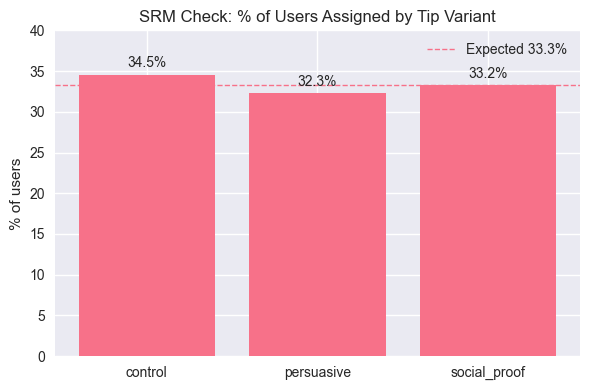

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

# 1) Pull assignment counts
srm_q = """
SELECT tip_test_group AS variant, COUNT(DISTINCT user_id) AS n_users
FROM v_user_experiment_assignments
WHERE tip_test_group IN ('control','persuasive','social_proof')
GROUP BY tip_test_group
"""
srm_df = conn.execute(srm_q).fetchdf()

# Order variants consistently
order = ['control','persuasive','social_proof']
srm_df = srm_df.set_index('variant').reindex(order).reset_index()

# 2) Chi-square vs equal split
obs = srm_df["n_users"].to_numpy()
expected = np.array([obs.sum()/len(obs)] * len(obs))
chi2_srm, p_srm = chisquare(f_obs=obs, f_exp=expected)

# % of users
srm_df["pct_users"] = 100 * srm_df["n_users"] / srm_df["n_users"].sum()

# Print tidy table + interpretation
print("=== SRM (Sample Ratio Mismatch) Check ===")
print(srm_df.assign(pct_users=srm_df["pct_users"].round(1)))
print(f"\nChi-square = {chi2_srm:.2f}, p-value = {p_srm:.3f}")
if p_srm > 0.05:
    print("✅ No evidence of SRM — assignments are balanced across variants.")
else:
    print("⚠️ Possible SRM — assignments differ significantly from expected ratios.")

# 3) Plot % of users by variant with expected 33.3% line
plt.figure(figsize=(6,4))
x = np.arange(len(srm_df))
plt.bar(x, srm_df["pct_users"])
for i, v in enumerate(srm_df["pct_users"]):
    plt.text(i, v + 0.6, f"{v:.1f}%", ha="center", va="bottom")

plt.axhline(100/3, linestyle="--", linewidth=1, label="Expected 33.3%")
plt.xticks(x, srm_df["variant"])
plt.ylabel("% of users")
plt.title("SRM Check: % of Users Assigned by Tip Variant")
plt.ylim(0, max(40, srm_df["pct_users"].max() + 5))
plt.legend()
plt.tight_layout()
plt.show()


# Temporal imbalance (weekday vs weekend, month effects)

=== Temporal Check — Weekday (variant mix by weekday) ===

Counts (distinct users):
variant    control  persuasive  social_proof
dow_label                                   
Mon            238         226           188
Tue            266         272           275
Wed            265         228           246
Thu            235         243           231
Fri            225         216           262
Sat            256         227           242
Sun            253         213           231

Row % (each weekday sums to ~100%):
variant    control  persuasive  social_proof
dow_label                                   
Mon           36.5        34.7          28.8
Tue           32.7        33.5          33.8
Wed           35.9        30.9          33.3
Thu           33.1        34.3          32.6
Fri           32.0        30.7          37.3
Sat           35.3        31.3          33.4
Sun           36.3        30.6          33.1

Chi-square = 15.97, p-value = 0.192
✅ No evidence of weekday imbalan

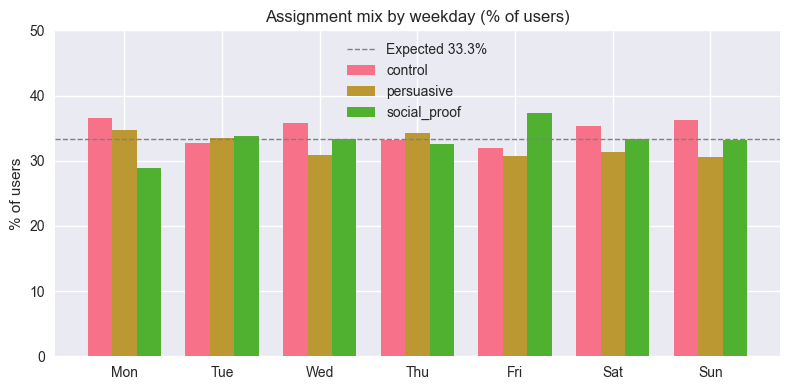


=== Temporal Check — Month (variant mix by month) ===

Counts (distinct users):
variant         control  persuasive  social_proof
assigned_month                                   
2025-03-01           18          14            20
2025-04-01          496         464           484
2025-05-01          537         456           453
2025-06-01          474         452           484
2025-07-01          213         239           234

Row % (each month sums to ~100%):
variant         control  persuasive  social_proof
assigned_month                                   
2025-03-01         34.6        26.9          38.5
2025-04-01         34.3        32.1          33.5
2025-05-01         37.1        31.5          31.3
2025-06-01         33.6        32.1          34.3
2025-07-01         31.0        34.8          34.1

Chi-square = 10.45, p-value = 0.235
✅ No evidence of monthly imbalance — variant shares are consistent across months.


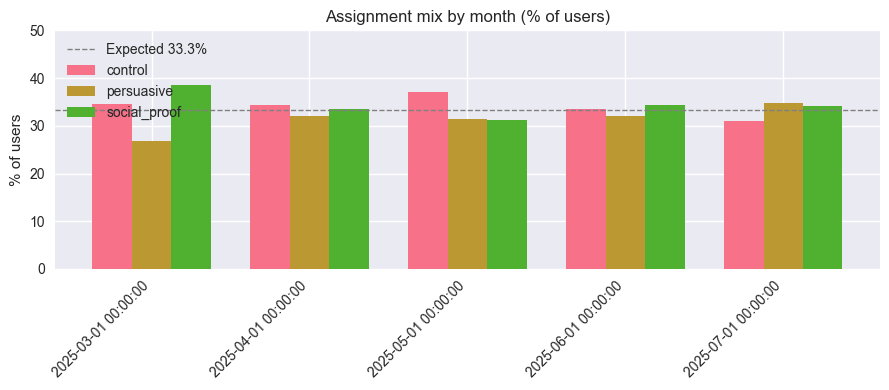

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ---------- 1) Pull TipPrompt assignments with time buckets ----------
tip_assign_q = """
SELECT
  assigned_at_utc::DATE                              AS assigned_date,
  assigned_dow                                       AS assigned_dow,    -- 0=Sun..6=Sat (adjust if different)
  DATE_TRUNC('month', assigned_at_utc)::DATE         AS assigned_month,
  variant,
  user_id
FROM v_ab_assignments_clean
WHERE experiment_name = 'TipPrompt_2025Q2'
  AND variant IN ('control','persuasive','social_proof')
"""
assign_df = conn.execute(tip_assign_q).fetchdf()

# Map DOW to labels (edit if your mapping differs)
dow_map = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'}
if assign_df['assigned_dow'].dtype.kind in 'iuf':
    assign_df['dow_label'] = assign_df['assigned_dow'].map(dow_map).fillna(assign_df['assigned_dow'].astype(str))
else:
    assign_df['dow_label'] = assign_df['assigned_dow']

variants = ['control','persuasive','social_proof']
dow_order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']  # nice display order

# ---------- 2) Weekday: counts, %, chi-square, message ----------
dow_counts = (assign_df
              .groupby(['dow_label','variant'])['user_id']
              .nunique()
              .unstack('variant', fill_value=0)
              .reindex(dow_order)
              .reindex(columns=variants, fill_value=0)
              .astype(int))

chi2_dow, p_dow, dof_dow, exp_dow = chi2_contingency(dow_counts.values)

dow_pct = dow_counts.div(dow_counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

print("=== Temporal Check — Weekday (variant mix by weekday) ===")
print("\nCounts (distinct users):")
print(dow_counts)
print("\nRow % (each weekday sums to ~100%):")
print(dow_pct.round(1))
print(f"\nChi-square = {chi2_dow:.2f}, p-value = {p_dow:.3f}")
if p_dow > 0.05:
    print("✅ No evidence of weekday imbalance — variant shares are consistent across weekdays.")
else:
    print("⚠️ Potential weekday imbalance — variant shares differ by weekday (p < 0.05).")

# ---------- 3) Plot — Weekday % by variant (grouped bars) ----------
fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(dow_pct.index))
width = 0.25
for i, v in enumerate(variants):
    vals = dow_pct[v].fillna(0).values
    ax.bar(x + i*width - width, vals, width, label=v)

ax.axhline(100/3, linestyle="--", linewidth=1, color="gray", label="Expected 33.3%")
ax.set_title("Assignment mix by weekday (% of users)")
ax.set_xticks(x)
ax.set_xticklabels(dow_pct.index)
ax.set_ylabel("% of users")
ax.set_ylim(0, max(50, np.nanmax(dow_pct.values) + 5))
ax.legend()
plt.tight_layout()
plt.show()

# ---------- 4) Month: counts, %, chi-square, message ----------
month_counts = (assign_df
                .groupby(['assigned_month','variant'])['user_id']
                .nunique()
                .unstack('variant', fill_value=0)
                .sort_index()
                .reindex(columns=variants, fill_value=0)
                .astype(int))

chi2_mo, p_mo, dof_mo, exp_mo = chi2_contingency(month_counts.values)

mo_pct = month_counts.div(month_counts.sum(axis=1).replace(0, np.nan), axis=0) * 100

print("\n=== Temporal Check — Month (variant mix by month) ===")
print("\nCounts (distinct users):")
print(month_counts)
print("\nRow % (each month sums to ~100%):")
print(mo_pct.round(1))
print(f"\nChi-square = {chi2_mo:.2f}, p-value = {p_mo:.3f}")
if p_mo > 0.05:
    print("✅ No evidence of monthly imbalance — variant shares are consistent across months.")
else:
    print("⚠️ Potential monthly imbalance — variant shares differ by month (p < 0.05).")

# ---------- 5) Plot — Month % by variant (grouped bars) ----------
fig, ax = plt.subplots(figsize=(9,4))
x = np.arange(len(mo_pct.index))
width = 0.25
for i, v in enumerate(variants):
    vals = mo_pct[v].fillna(0).values
    ax.bar(x + i*width - width, vals, width, label=v)

ax.axhline(100/3, linestyle="--", linewidth=1, color="gray", label="Expected 33.3%")
ax.set_title("Assignment mix by month (% of users)")
ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in mo_pct.index], rotation=45, ha='right')
ax.set_ylabel("% of users")
ax.set_ylim(0, max(50, np.nanmax(mo_pct.values) + 5))
ax.legend()
plt.tight_layout()
plt.show()


# Whether treatment effects vary by risk decile (heterogeneity / simple interaction)

In [16]:
import pandas as pd, numpy as np

het_q = """
SELECT
  tip_test_group,
  price_test_group,
  risk_score_decile,
  province,
  amount,
  revenue,
  tip_amount,
  is_default
FROM v_loans_with_experiments
WHERE is_disbursed = 1
"""
het_df = conn.execute(het_q).fetchdf()
het_df["tip_taken"] = (het_df["tip_amount"] > 0).astype(int)

het_df.head()


,tip_test_group,price_test_group,risk_score_decile,province,amount,revenue,tip_amount,is_default,tip_taken
0,persuasive,not_assigned,1,QC,92.25,0.00,0.0,1,0
1,persuasive,B,1,BC,158.24,3.05,1.0,0,1
2,social_proof,A,1,SK,120.76,0.00,0.0,1,0
3,social_proof,B,1,MB,129.85,4.92,0.0,0,0
4,persuasive,B,1,BC,96.35,4.29,0.0,0,0


In [17]:
# Scale continuous features to avoid huge linear predictors
het_df = het_df.copy()
het_df["amount_k"] = het_df["amount"] / 1000.0

# Bucket rare provinces (prevents quasi-separation)
min_count = 20
prov_counts = het_df["province"].value_counts()
rare_provs = prov_counts[prov_counts < min_count].index
het_df.loc[het_df["province"].isin(rare_provs), "province"] = "OTHER"

# Ensure expected categories exist
het_df["tip_test_group"]   = het_df["tip_test_group"].astype("category")
het_df["price_test_group"] = het_df["price_test_group"].astype("category")
het_df["province"]         = het_df["province"].astype("category")


In [18]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

deciles = sorted(het_df["risk_score_decile"].dropna().unique())
rows = []

for d in deciles:
    sub = het_df[het_df["risk_score_decile"] == d].copy()
    if len(sub) < 50:   # skip tiny strata to avoid instability
        continue

    formula_take_dec = """
    tip_taken ~ C(tip_test_group, Treatment('control'))
             + C(price_test_group, Treatment('A'))
             + C(province)
             + amount_k
    """
    try:
        m = smf.logit(formula_take_dec, data=sub).fit(disp=0, method="lbfgs", maxiter=300)
    except Exception:
        # Fallback to GLM Binomial if Logit struggles
        m = smf.glm(formula_take_dec, data=sub, family=sm.families.Binomial()).fit()

    # Average marginal effects (vs control), using your column names
    ame = m.get_margeff(at='overall', method='dydx')
    sf  = ame.summary_frame()

    eff_col = "dy/dx"
    p_col   = "Pr(>|z|)"
    lo_col  = "Conf. Int. Low"
    hi_col  = "Cont. Int. Hi."

    for term, label in [
        ("C(tip_test_group, Treatment('control'))[T.persuasive]",   "persuasive"),
        ("C(tip_test_group, Treatment('control'))[T.social_proof]", "social_proof"),
    ]:
        if term in sf.index:
            rows.append({
                "risk_decile": int(d),
                "tip_variant": label,
                "effect_pp":  100 * sf.loc[term, eff_col],
                "ci_low_pp":  100 * sf.loc[term, lo_col],
                "ci_high_pp": 100 * sf.loc[term, hi_col],
                "p_value":    float(sf.loc[term, p_col]),
                "n":          len(sub),
            })

het_take_df = pd.DataFrame(rows).sort_values(["risk_decile","tip_variant"]).reset_index(drop=True)
het_take_df = het_take_df.round({"effect_pp":2,"ci_low_pp":2,"ci_high_pp":2,"p_value":3})
het_take_df


,risk_decile,tip_variant,effect_pp,ci_low_pp,ci_high_pp,p_value,n
0,1,persuasive,-2.73,-10.37,4.91,0.484,432
1,1,social_proof,-0.46,-8.44,7.52,0.910,432
2,2,persuasive,-5.40,-13.81,3.02,0.209,455
3,2,social_proof,-3.14,-11.68,5.39,0.471,455
4,3,persuasive,9.26,0.64,17.88,0.035,460
5,3,social_proof,2.28,-7.47,12.04,0.646,460
6,4,persuasive,2.83,-6.09,11.74,0.534,446
7,4,social_proof,0.39,-8.49,9.26,0.932,446
8,5,persuasive,9.45,0.09,18.80,0.048,404
9,5,social_proof,6.37,-3.36,16.10,0.199,404


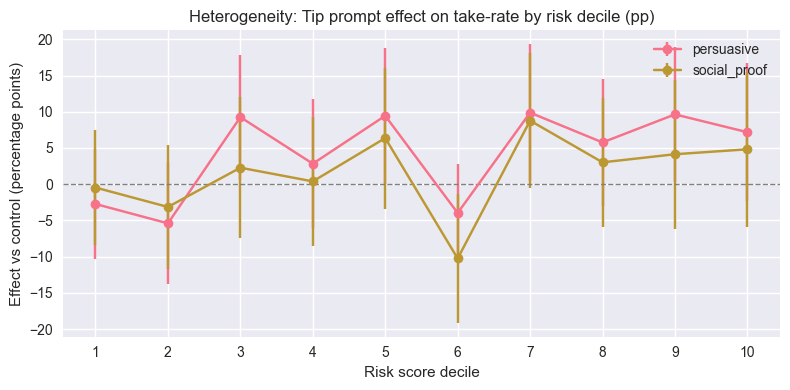

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))
for v in ["persuasive","social_proof"]:
    sub = het_take_df[het_take_df["tip_variant"]==v]
    if sub.empty: 
        continue
    x = sub["risk_decile"].values.astype(float)
    y = sub["effect_pp"].values
    yerr_low  = np.maximum(0, y - sub["ci_low_pp"].values)
    yerr_high = np.maximum(0, sub["ci_high_pp"].values - y)
    ax.errorbar(x, y, yerr=[yerr_low, yerr_high], fmt='o-', label=v)

ax.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_title("Heterogeneity: Tip prompt effect on take-rate by risk decile (pp)")
ax.set_xlabel("Risk score decile")
ax.set_ylabel("Effect vs control (percentage points)")
ax.set_xticks(sorted(het_take_df["risk_decile"].unique()))
ax.legend()
plt.tight_layout()
plt.show()


In [20]:
# Create summary flags from het_take_df (up to step 3)
summary_flags = het_take_df.copy()

# Significance flag
summary_flags["is_sig"] = summary_flags["p_value"] < 0.05

# Direction flag
summary_flags["direction"] = np.where(summary_flags["effect_pp"] > 0, "positive", "negative")

# Strength flag (large effect >5pp in absolute terms)
summary_flags["large_effect"] = np.where(abs(summary_flags["effect_pp"]) > 5, True, False)

# Keep only useful columns
summary_flags = summary_flags[[
    "risk_decile","tip_variant","effect_pp","ci_low_pp","ci_high_pp",
    "p_value","is_sig","direction","large_effect","n"
]]

summary_flags


,risk_decile,tip_variant,effect_pp,ci_low_pp,ci_high_pp,p_value,is_sig,direction,large_effect,n
0,1,persuasive,-2.73,-10.37,4.91,0.484,False,negative,False,432
1,1,social_proof,-0.46,-8.44,7.52,0.910,False,negative,False,432
2,2,persuasive,-5.40,-13.81,3.02,0.209,False,negative,True,455
3,2,social_proof,-3.14,-11.68,5.39,0.471,False,negative,False,455
4,3,persuasive,9.26,0.64,17.88,0.035,True,positive,True,460
5,3,social_proof,2.28,-7.47,12.04,0.646,False,positive,False,460
6,4,persuasive,2.83,-6.09,11.74,0.534,False,positive,False,446
7,4,social_proof,0.39,-8.49,9.26,0.932,False,positive,False,446
8,5,persuasive,9.45,0.09,18.80,0.048,True,positive,True,404
9,5,social_proof,6.37,-3.36,16.10,0.199,False,positive,True,404


In [21]:
conn.close()